# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import urllib
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

Данные находятся в трёх файлах:
- gold_recovery_train_new.csv — обучающая выборка;
- gold_recovery_test_new.csv — тестовая выборка;
- gold_recovery_full_new.csv — исходные данные.

Ссылки на датасеты удалены из проекта, чтобы не нарушать авторские права Яндекса.

In [2]:
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден и будет загружен из сети')
        _ = urllib.request.urlretrieve(url, file_name)

urls = {
    'train': ('datasets/gold_recovery_train.csv',
              'https://'),
    'test': ('datasets/gold_recovery_test.csv',
             'https://'),
    'full': ('datasets/gold_recovery_full.csv',
             'https://')
}

[get_file(*urls[k]) for k in urls]

data_train = pd.read_csv(urls['train'][0], index_col=0)
data_test = pd.read_csv(urls['test'][0], index_col=0)
data_full = pd.read_csv(urls['full'][0], index_col=0)

Проиндексировали данные датой и временем получения информации (признак date)

Данные сырые - прежде чем приступить к построению модели, проверим их на корректность.

In [3]:
data_full.index.symmetric_difference(data_test.index).symmetric_difference(data_train.index)

Index([], dtype='object', name='date')

Убедились, что data_full содержит все данные из test и train.

In [4]:
data_full.info()
data_train.info()
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

В train и full 84 признака + 2 целевых (final.output.recovery и rougher.output.recovery), в тест - 52 признака, целевые отсутствуют. Практически все признаки в датасетах содержат пропуски.

In [5]:
data_check = data_train.dropna()

def recovery(c, f, t):
    return (c * (f - t)) / (f * (c - t)) * 100

rougher_recovery = recovery(data_check['rougher.output.concentrate_au'],
                            data_check['rougher.input.feed_au'],
                            data_check['rougher.output.tail_au'])

mean_absolute_error(data_check['rougher.output.recovery'], rougher_recovery)

9.460144184559453e-15

Проверку верности расчета эффективности обогащения сделаем на тренировочных данных, организовав временный датасет и удалив из данных все пропуски.

Эффективность обогащения рассчитана правильно, MAE между расчётным значением и значением признака в выборке близко к нулю, ненулевое - из-за неточности чисел с плавающей запятой.

In [6]:
set(data_train.columns) - set(data_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Признаки, отсутствующие в тестовой выборке - расчетные (calculation) и выходные (output) характеристики процесса - мы получаем в процессе очистки (то есть они не доступны на старте, т.к. их невозможно получить/измерить во время выполнения технологического процесса), следовательно использовать их в модели не получится, поэтому в тренировочных данных стоит оставить только те признаки, которые есть в тестовых. Целевые колонки недоступны в тестовых данных, нужно извлечь их из full датасета по дате.

In [7]:
target_train = data_train[['rougher.output.recovery', 'final.output.recovery']]
features_train = data_train[data_test.columns]
target_test = data_full.loc[data_test.index][['rougher.output.recovery', 'final.output.recovery']]
features_test = data_test

Перейдем к предобработке данных. Проверим, как распределены пропуски в данных.

In [8]:
print(features_train[features_train.isna().sum(axis=1) > 0].isna().sum(axis=1).describe(),'\n',
      features_test[features_test.isna().sum(axis=1) > 0].isna().sum(axis=1).describe())

count    3338.000000
mean        3.795087
std         5.944954
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max        51.000000
dtype: float64 
 count    473.000000
mean       4.989429
std        8.794373
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max       51.000000
dtype: float64


Видим, что распределение пропусков носит несимметричный характер. К примеру, в половине из 3338 строк с пропусками в тренировочном датасете всего 1 или 2 пропуска, таким образом, удаляя строки с пропусками, мы потеряем много полезных данных. Однако есть и строки, в которых пропущен 51 признак - их можно смело удалять. Также удалим строки с пропусками в целевых столбцах.

In [9]:
features_train = features_train.dropna(thresh=2)
features_test = features_test.dropna(thresh=2)

Оставим строки с, как минимум, двумя значениями, отличными от NA.

In [10]:
print('Число пропущенных значений final recovery в обучающей выборке, которые есть в исходной -',
      target_train['final.output.recovery'].isna().sum() -
      len(data_full[data_full['final.output.recovery'].isna()].index.intersection( 
          target_train[target_train['final.output.recovery'].isna()].index)))

print('Число пропущенных значений rougher recovery в обучающей выборке, которые есть в исходной -',
      target_train['rougher.output.recovery'].isna().sum() -
      len(data_full[data_full['rougher.output.recovery'].isna()].index.intersection(
          target_train[target_train['rougher.output.recovery'].isna()].index)))

Число пропущенных значений final recovery в обучающей выборке, которые есть в исходной - 0
Число пропущенных значений rougher recovery в обучающей выборке, которые есть в исходной - 0


Проверили: нельзя ли заполнить пропущенные в обучающей выборке целевые признаки данными из исходной выборки. Нельзя: соответстующие значения также пропущены - удаляем строки с пропусками в целевых столбцах.

In [11]:
target_train = target_train.dropna()
target_test = target_test.dropna()

In [12]:
features_train = features_train.loc[features_train.index.isin(target_train.index)]
features_test = features_test.loc[features_test.index.isin(target_test.index)]

Убрали строки с признаками, соответвующими пропускам в целевых столбцах.

Осталось только избавиться от NA в признаках. Заполним их соседними с помощью ffill, так как соседние по времени параметры часто похожи.

In [13]:
features_train = features_train.fillna(method='ffill')
features_test = features_test.fillna(method='ffill')

Данные предобработаны.

# 2. Анализ данных

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

In [14]:
def print_boxplot_by_column(c1,c2,c3):
    plt.figure(figsize=(10,6))
    plt.title('Распределение концентрации на выходе этапов')
    sns.boxplot(data=data_full[[c1, c2, c3]], orient="h")

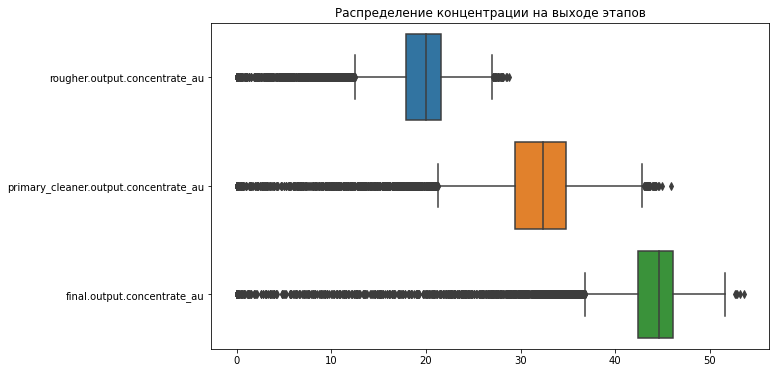

In [15]:
print_boxplot_by_column('rougher.output.concentrate_au',
                        'primary_cleaner.output.concentrate_au',
                        'final.output.concentrate_au')

Видим, что концентрация золота растет с каждым этапом, флотация (обогащение) и двухэтапная очистка служат как раз для повышения его концентрации.

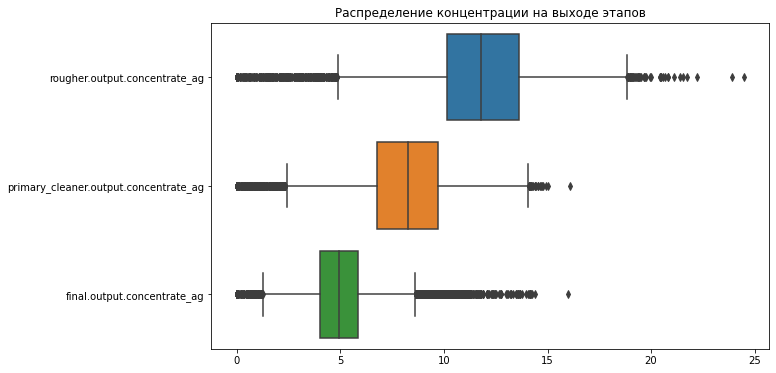

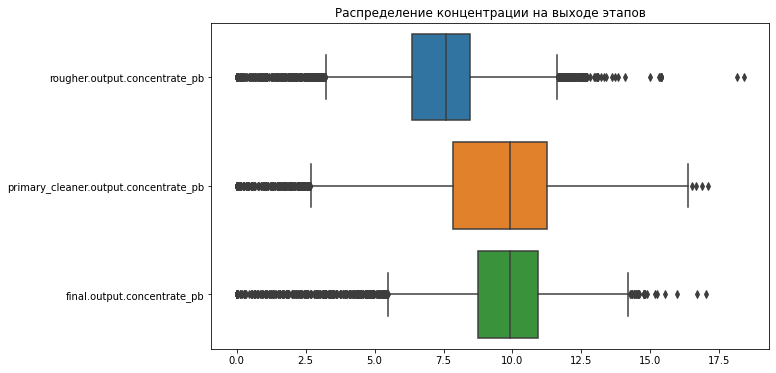

In [16]:
print_boxplot_by_column('rougher.output.concentrate_ag',
                        'primary_cleaner.output.concentrate_ag',
                        'final.output.concentrate_ag')
print_boxplot_by_column('rougher.output.concentrate_pb',
                        'primary_cleaner.output.concentrate_pb',
                        'final.output.concentrate_pb')

Концентрация серебра напротив уменьшается с каждый шагом. Концентрация свинца повышается в период с флотации до первичной очистки, а потом усредняется.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

/Users/diana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/diana/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Распределение размеров гранул сырья перед первичной очисткой на обучающей и тестовой выборках'}, xlabel='Размер гранул сырья', ylabel='Плотность распределения'>

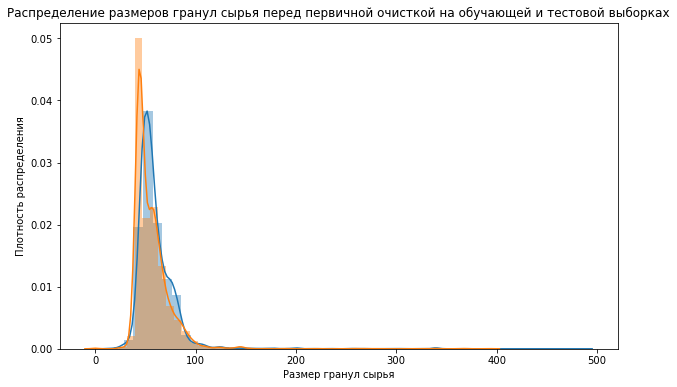

In [17]:
plt.figure(figsize=(10,6))
plt.title('Распределение размеров гранул сырья перед первичной очисткой на обучающей и тестовой выборках')
plt.xlabel("Размер гранул сырья")
plt.ylabel("Плотность распределения")

sns.distplot(features_train['rougher.input.feed_size'], axlabel=False)
sns.distplot(features_test['rougher.input.feed_size'], axlabel=False)

Распределения размеров гранул сырья на обучающей и тестовой выборках похожи на глаз, для нас сейчас этого достаточно, если бы распределения сильно отличались друг от друга, оценка модели была бы неправильной.

Исследуем теперь суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [18]:
data_full['rougher.input.feed_sum'] = (data_full['rougher.input.feed_ag'] +
                                               data_full['rougher.input.feed_au'] +
                                               data_full['rougher.input.feed_pb'] +
                                               data_full['rougher.input.feed_sol'])

data_full['rougher.output.concentrate_sum'] = (data_full['rougher.output.concentrate_ag'] +
                                               data_full['rougher.output.concentrate_au'] +
                                               data_full['rougher.output.concentrate_pb'] +
                                               data_full['rougher.output.concentrate_sol'])


data_full['primary_cleaner.output.concentrate_sum'] = (data_full['primary_cleaner.output.concentrate_ag'] +
                                                       data_full['primary_cleaner.output.concentrate_au'] +
                                                       data_full['primary_cleaner.output.concentrate_pb'] +
                                                       data_full['primary_cleaner.output.concentrate_sol'])

data_full['final.output.concentrate_sum'] = (data_full['final.output.concentrate_ag'] +
                                             data_full['final.output.concentrate_au'] +
                                             data_full['final.output.concentrate_pb'] +
                                             data_full['final.output.concentrate_sol'])

In [19]:
data_full.loc[:, 'rougher.input.feed_sum':'final.output.concentrate_sum'].describe()

,rougher.input.feed_sum,rougher.output.concentrate_sum,primary_cleaner.output.concentrate_sum,final.output.concentrate_sum
count,22241.000000,22526.000000,21918.000000,22328.000000
mean,52.273449,61.799418,55.471318,62.475148
std,17.653233,23.168341,19.757606,20.744652
min,0.000000,0.000000,0.000000,0.000000
25%,51.784664,63.558831,57.230377,67.200835
50%,56.939323,69.459530,61.957870,69.294183
75%,61.519755,74.058219,65.402045,71.165495
max,76.978947,90.964431,80.749343,80.210644


In [20]:
print('Количество нулевых концентраций в сырье, после обогащения, первичной очистки и в финальном концентрате, соответственно:\n',
      (data_full['rougher.input.feed_sum'] == 0).sum(),
      (data_full['rougher.output.concentrate_sum'] == 0).sum(),
      (data_full['primary_cleaner.output.concentrate_sum'] == 0).sum(),
      (data_full['final.output.concentrate_sum'] == 0).sum())

Количество нулевых концентраций в сырье, после обогащения, первичной очистки и в финальном концентрате, соответственно:
 1528 1953 1626 1613


Нулевые концентрации в суммарном распределении на всех стадиях выглядят аномально, они могут быть вызваны ошибкой оборудования - их стоит удалить из обеих выборок.

In [21]:
index_with_zero_conc = (data_full[data_full['rougher.input.feed_sum'] == 0].index |
                        data_full[data_full['rougher.output.concentrate_sum'] == 0].index |
                        data_full[data_full['primary_cleaner.output.concentrate_sum'] == 0].index |
                        data_full[data_full['final.output.concentrate_sum'] == 0].index)
len(index_with_zero_conc)

<ipython-input-21-5627d0e045d7>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index_with_zero_conc = (data_full[data_full['rougher.input.feed_sum'] == 0].index |
<ipython-input-21-5627d0e045d7>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index_with_zero_conc = (data_full[data_full['rougher.input.feed_sum'] == 0].index |
<ipython-input-21-5627d0e045d7>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index_with_zero_conc = (data_full[data_full['rougher.input.feed_sum'] == 0].index |


2380

Получили индексы 2380 строк, в которых встречается нулевая суммарная концентрация на одном из этапов, удалим строки с этими индексами из тренировочной и тестовой выборок.

In [22]:
features_train = features_train[~features_train.index.isin(index_with_zero_conc)]
target_train = target_train[~target_train.index.isin(index_with_zero_conc)]
features_test = features_test[~features_test.index.isin(index_with_zero_conc)]
target_test = target_test[~target_test.index.isin(index_with_zero_conc)]

Данные проанализированы, очищены от аномалий и готовы к обучению модели.

# 3. Модель

Напишем функцию для вычисления итоговой sMAPE:

$$
sMAPE = \frac{1}{N}\sum\limits_{i=1}^{N}\frac{|y_{i}-\hat{y_{i}}|}{(|y_{i}|+|\hat{y_{i}}|)/2}*100\% 
$$

Итоговое sMAPE = 25% * sMAPE(rougher) + 75% * sMAPE(final)

In [23]:
def smape(y_true, y_pred):
    smape = 100 / len(y_true) * (np.abs(y_true - y_pred) /
                                 ((np.abs(y_true) + np.abs(y_pred)) / 2)).sum()
    final_smape = 0.25 * smape[0] + 0.75 * smape[1]
    return final_smape

In [24]:
smape_scorer = make_scorer(smape, greater_is_better=False)

Обучим разные модели и оценим их качество кросс-валидацией

In [25]:
# зафиксируем значение параметра random_state, чтобы результаты нашей работы были воспроизводимы
state = 12345

In [26]:
%%time
grid_params_rf = {'max_depth': range(1,10),
                  'n_estimators': range(1,61,20)}

rf = RandomForestRegressor(random_state=state)

RF = GridSearchCV(rf, grid_params_rf,
                        cv=3, scoring=smape_scorer)

RF.fit(features_train, target_train)

CPU times: user 2min 51s, sys: 235 ms, total: 2min 51s
Wall time: 2min 51s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 61, 20)},
             scoring=make_scorer(smape, greater_is_better=False))

In [27]:
print('sMAPE RandomForest при кросс-валидации', RF.best_score_)
RF.best_params_

sMAPE RandomForest при кросс-валидации -9.979832731641864


{'max_depth': 4, 'n_estimators': 41}

Отрицательное значение sMAPE обсуловлено параметром скорера greater_is_better=False, так как GridSearchCV всегда максимизирует значение метрики, а нам необходимо выбирать наименьшее значение ошибки, мы передаем в GridSearchCV отрицательную версию нашей метрики, таким образом значение метрики -9.98, нужно рассматривать по модулю 9.98. Переходим к DecisionTreeRegressor.

In [28]:
%%time
grid_params_dt = {'max_depth': range(1,10)}
dt = DecisionTreeRegressor(random_state=state)
DT = GridSearchCV(dt, grid_params_dt,
                  cv=3, scoring=smape_scorer)
DT.fit(features_train, target_train)

CPU times: user 4.67 s, sys: 6.42 ms, total: 4.68 s
Wall time: 4.68 s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(1, 10)},
             scoring=make_scorer(smape, greater_is_better=False))

In [29]:
print('sMAPE Decision Tree при кросс-валидации', DT.best_score_)
DT.best_params_

sMAPE Decision Tree при кросс-валидации -10.253142617688159


{'max_depth': 4}

DecisionTreeRegressor показывает значение целевой метрики sMAPE немного хуже, чем RandomForest. Посмотрим теперь, как обучится линейная регрессия, без использования кросс-валидации.

In [30]:
LR = LinearRegression()
LR.fit(features_train, target_train)
print('sMAPE LinearRegression на тренировочной выборке', smape(target_train, LR.predict(features_train)))

sMAPE LinearRegression на тренировочной выборке 7.1813603362063425


Линейная регрессия на тренировочной выборке показывает значения лучше, чем две предыдущие модели, но поскольку для предыдущих моделей использовалась кросс-валидация для подбора гиперпараметров, предположительно их метрики будут более стабильны на тестовой выборке.

In [31]:
print('sMAPE LinearRegression на тестовой выборке', smape(target_test, LR.predict(features_test)))
predictions_test = RF.predict(features_test)
print('sMAPE RandomForest на тестовой выборке', smape(target_test, predictions_test))
predictions_test = DT.predict(features_test)
print('sMAPE Decision Tree на тестовой выборке', smape(target_test, predictions_test))

sMAPE LinearRegression на тестовой выборке 7.316037194142444
sMAPE RandomForest на тестовой выборке 7.521471719894999
sMAPE Decision Tree на тестовой выборке 10.20911029336526


И снова лучший результат у линейной регрессии, сделаем проверку на вменяемость с помощью DummyRegressor.

In [32]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(features_train, target_train)
smape(target_test, dummy_regr.predict(features_test))

7.369167385832511

Прототип модели машинного обучения имеет бесконечный потенциал к улучшению) лучшая из наших моделей показала результат, сопоставимый со случайным с медианными значениями целевых признаков из тренировочной выборки, в рамках данного проекта это допустимо. Чтоооож.

Вот, что можно попробовать сделать для улучшения качества модели:
1) поработать с качеством данных на входе: ещё раз оценить аномалии, пропуски, соответствие физике (правдиво ли всё)

2) поискать упущенные бизнес-факторы для моделирования или сгенерировать что-то гибридное из имеющихся факторов

3) провести более тщательный подбор параметров моделей    

4) возможно, нужно было использовать 2 модели - по одной на предсказание значений обоих целевых признаков

Таким образом, мы прошли три этапа:
1. Подготовили данные;
2. Провели исследовательский анализ данных;
3. Построили и обучили модель.

Была получена модель, предсказывающая коэффициент восстановления золота из золотосодержащей руды с наибольшим показателем sMAPE на тестовой выборке - 7.316. Лучший результат показала линейная регрессия, немного хуже результат у Случайного леса - sMAPE = 7.521 на тестовой выборке, хуже всего обучилось Дерево принятия решений (sMAPE = 10.209).